In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# Load the HI data cube
file_path = "/Users/livisilcock/Documents/PROJECTS/NGC5102/fits/HI_cube.fits"
f = fits.open(file_path)
data = f[0].data[0, :, :, :]  # Extract the data cube (velocity, y, x)


# Plotting

## Convert Jy/Beam → Jy/Pixel

In [3]:
bmaj = f[0].header['BMAJ'] * u.deg  # Beam major axis
bmin = f[0].header['BMIN'] * u.deg  # Beam minor axis

# Get pixel scale in degrees
wcs = WCS(f[0].header)
pixel_scale_x = np.abs(wcs.pixel_scale_matrix[0, 0])  # Degrees per pixel
pixel_scale_y = np.abs(wcs.pixel_scale_matrix[1, 1])  # Degrees per pixel
pixel_area_deg2 = pixel_scale_x * pixel_scale_y

# Compute beam area in degrees squared
beam_area_deg2 = (np.pi * (bmaj * bmin) / (4 * np.log(2))).to(u.deg**2).value

# Compute correction factor and apply it
beam_correction_factor = beam_area_deg2 / pixel_area_deg2  # Convert Jy/beam → Jy/pixel
data /= beam_correction_factor  # Corrected data
print(f"Beam Correction Factor: {beam_correction_factor:.3f} (Jy/beam → Jy/pixel)")


Beam Correction Factor: 132.976 (Jy/beam → Jy/pixel)


## Apply Gaussian Filtering & Masking

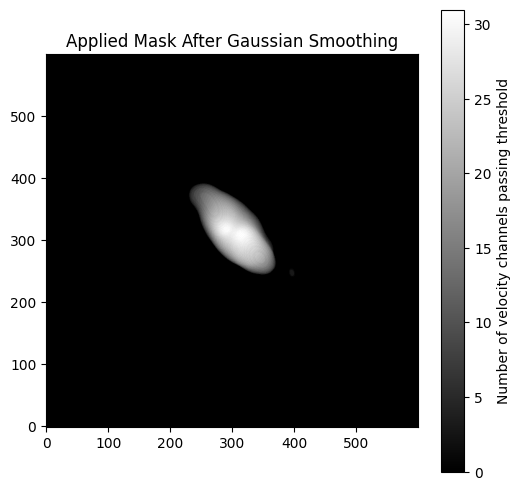

In [4]:
velocity_min, velocity_max = 20, 60  # Velocity range of strong HI signal
y_min, y_max = 290, 330  # Tightly mask the Y range
x_min, x_max = 290, 330  # Tightly mask the X range

# Convert beam major/minor axis to pixels
sigma_major = (bmaj.to(u.arcsec).value / (pixel_scale_x * 3600))
sigma_minor = (bmin.to(u.arcsec).value / (pixel_scale_y * 3600))
sigma_velocity = 4  # Recommended by KinMS

# Smooth data cube before masking
smoothed_data = gaussian_filter(data, sigma=[sigma_velocity, sigma_major, sigma_minor])

# Define threshold for masking
flux_threshold = 5 * np.nanstd(smoothed_data)  # 5 times noise standard deviation

# Create mask based on smoothed data
mask = smoothed_data > flux_threshold

# Apply mask to original (not smoothed) data
masked_data = np.where(mask, data, np.nan)

# Plot the mask to visualize
plt.figure(figsize=(6, 6))
plt.imshow(np.nansum(mask, axis=0), origin='lower', cmap='gray')
plt.colorbar(label="Number of velocity channels passing threshold")
plt.title("Applied Mask After Gaussian Smoothing")
plt.show()

## Integrate Flux  

In [5]:
# Extract velocity channel width in km/s
channel_width_kms = abs(f[0].header['CDELT3']) / 1000  # Convert m/s to km/s

# Sum spatially per velocity channel
flux_per_channel = np.nansum(masked_data, axis=(1, 2))

# Compute the integrated flux
integrated_flux = np.nansum(flux_per_channel) * channel_width_kms  # Jy km/s
print(f"Final Integrated Flux (Jy km/s): {integrated_flux:.2e}")


Final Integrated Flux (Jy km/s): 8.17e+01


## Plot Integrated Flux (Moment 0 Map)

Final Corrected HI Mass: 3.08e+08 M_sun


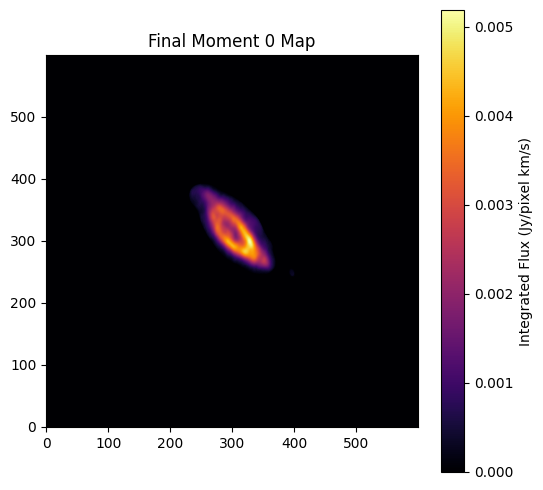

In [6]:
# Compute HI Mass
D = 4.0 # Distance in Mpc for NGC 5102
M_HI = 2.36e5 * (D ** 2) * integrated_flux  # HI mass formula

print(f"Final Corrected HI Mass: {M_HI:.2e} M_sun")

moment0_map = np.nansum(masked_data, axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(moment0_map, origin='lower', cmap='inferno')
plt.colorbar(label="Integrated Flux (Jy/pixel km/s)")
plt.title("Final Moment 0 Map")
plt.show()

## Compute the Correct Velocity Axis

In [7]:
# Systemic velocity from the Mitzkus paper
systemic_velocity = 474.5  # km/s

# Extract velocity axis directly from the FITS header
reference_velocity = f[0].header['CRVAL3'] / 1000  # Central velocity in km/s
channel_width = f[0].header['CDELT3'] / 1000  # Channel width in km/s
n_channels = data.shape[0]

# Compute the velocity axis for each channel
velocity_axis = reference_velocity + (np.arange(n_channels) - f[0].header['CRPIX3'] + 1) * channel_width
velocity_axis -= systemic_velocity  # Subtract systemic velocity to center around 0

# Print diagnostics
print(f"Velocity Axis Range After Fix: {velocity_axis.min()} km/s to {velocity_axis.max()} km/s")


Velocity Axis Range After Fix: -174.5 km/s to 161.5 km/s


## Plot the Moment 1 Map

Moment 1 Map Min: -102.63441391597343 km/s, Max: 92.36287445165352 km/s


/var/folders/ly/pqyt_cdd5q72016_nzqq24pc0000gn/T/ipykernel_3466/3756782997.py:3: RuntimeWarning: invalid value encountered in divide
  moment1_map = moment1_numerator / moment0_map


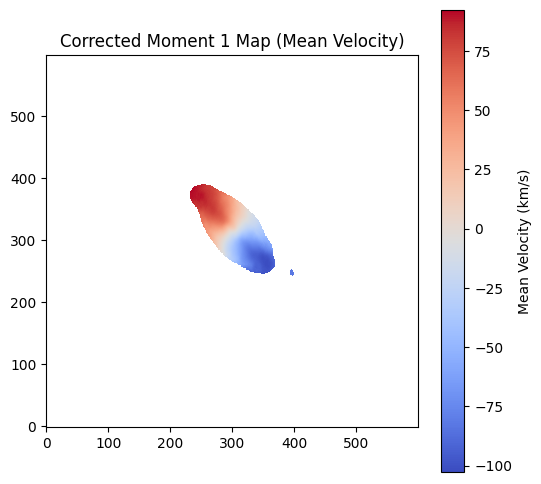

In [8]:
# Compute Moment 1 (Mean Velocity)
moment1_numerator = np.nansum(masked_data * velocity_axis[:, None, None], axis=0)
moment1_map = moment1_numerator / moment0_map
moment1_map[np.isnan(moment0_map)] = np.nan  # Mask invalid regions

# Print diagnostics
print(f"Moment 1 Map Min: {np.nanmin(moment1_map)} km/s, Max: {np.nanmax(moment1_map)} km/s")


plt.figure(figsize=(6, 6))
plt.imshow(moment1_map, origin='lower', cmap='coolwarm')
plt.colorbar(label="Mean Velocity (km/s)")
plt.title("Corrected Moment 1 Map (Mean Velocity)")
plt.show()


## Plot Moment 2

/var/folders/ly/pqyt_cdd5q72016_nzqq24pc0000gn/T/ipykernel_3466/3443903892.py:3: RuntimeWarning: invalid value encountered in divide
  moment2_map = np.sqrt(moment2_numerator / moment0_map)
/var/folders/ly/pqyt_cdd5q72016_nzqq24pc0000gn/T/ipykernel_3466/3443903892.py:3: RuntimeWarning: invalid value encountered in sqrt
  moment2_map = np.sqrt(moment2_numerator / moment0_map)


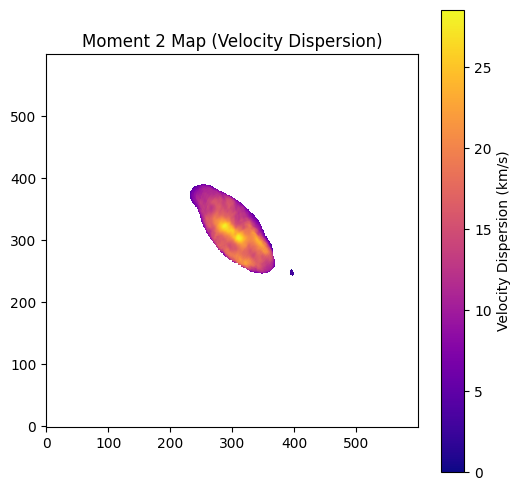

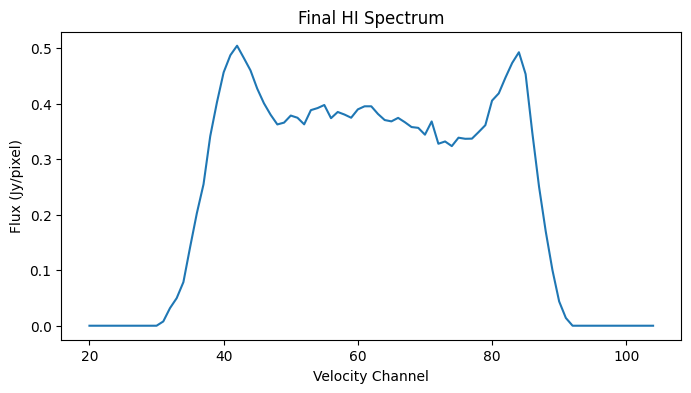

In [9]:
# Compute Moment 2 (Velocity Dispersion)
moment2_numerator = np.nansum(masked_data * (velocity_axis[:, None, None] - moment1_map[None, :, :])**2, axis=0)
moment2_map = np.sqrt(moment2_numerator / moment0_map)
moment2_map[np.isnan(moment0_map)] = np.nan  # Mask empty regions

plt.figure(figsize=(6, 6))
plt.imshow(moment2_map, origin='lower', cmap='plasma')
plt.colorbar(label="Velocity Dispersion (km/s)")
plt.title("Moment 2 Map (Velocity Dispersion)")
plt.show()


# Plot the Spectrum
velocity_channels = np.arange(len(flux_per_channel)) + velocity_min
plt.figure(figsize=(8, 4))
plt.plot(velocity_channels, flux_per_channel)
plt.xlabel("Velocity Channel")
plt.ylabel("Flux (Jy/pixel)")
plt.title("Final HI Spectrum")
plt.show()



## Uncertainties

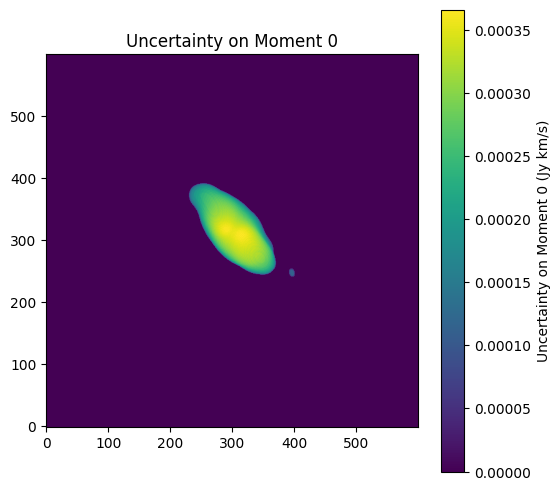

/var/folders/ly/pqyt_cdd5q72016_nzqq24pc0000gn/T/ipykernel_3466/1096277485.py:15: RuntimeWarning: invalid value encountered in divide
  uncertainty_moment1 = (delta_v_line / (2 * np.sqrt(3))) * (uncertainty_moment0 / moment0_map)  # u_vel from Equation 3


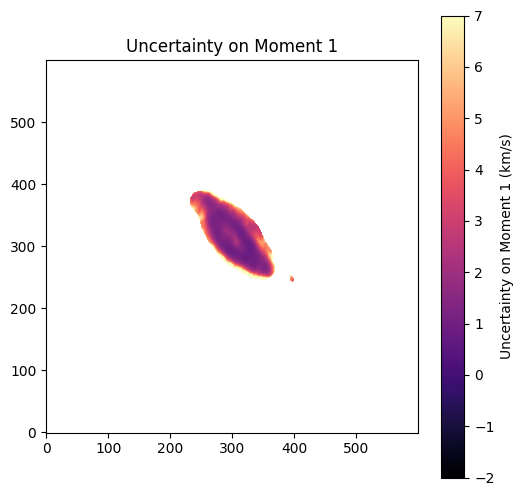

In [10]:
# Compute Uncertainty on Moment 0 (Integrated Intensity)
N_channels = np.sum(mask, axis=0)  # Number of channels included in the mask
sigma_rms = np.nanstd(data)  # RMS noise across the data cube
uncertainty_moment0 = np.sqrt(N_channels) * sigma_rms * channel_width_kms  # u_I from Equation 2

# Plot the Uncertainty on Moment 0
plt.figure(figsize=(6, 6))
plt.imshow(uncertainty_moment0, origin='lower', cmap='viridis')
plt.colorbar(label="Uncertainty on Moment 0 (Jy km/s)")
plt.title("Uncertainty on Moment 0")
plt.show()

# Compute Uncertainty on Moment 1 (Velocity Field)
delta_v_line = velocity_max - velocity_min  # Spectral line width
uncertainty_moment1 = (delta_v_line / (2 * np.sqrt(3))) * (uncertainty_moment0 / moment0_map)  # u_vel from Equation 3

# Plot the Uncertainty on Moment 1
plt.figure(figsize=(6, 6))
plt.imshow(uncertainty_moment1, origin='lower', cmap='magma', vmin=-2, vmax=7)
plt.colorbar(label="Uncertainty on Moment 1 (km/s)")
plt.title("Uncertainty on Moment 1")
plt.show()  # u_vel from Equation 3


# Gas Model

## No mask on centre

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from mgefit.find_galaxy import find_galaxy
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from astropy.wcs.utils import proj_plane_pixel_scales

In [15]:
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS

wcs = WCS(f[0].header)
scales = proj_plane_pixel_scales(wcs) * 3600  # Convert from deg/pixel to arcsec/pixel
HI_SCALE = (scales[0] + scales[1]) / 2        # Average x and y if needed


In [16]:
scales = proj_plane_pixel_scales(WCS(f[0].header)) * 3600
HI_SCALE = (scales[0] + scales[1]) / 2


 Pixels used: 11383
 Peak Img[j, k]: 304 323
 Mean (j, k): 313.20 303.70
 Theta (deg): 49.3
 Astro PA (deg): 40.7
 Eps: 0.596
 Major axis (pix): 99.5


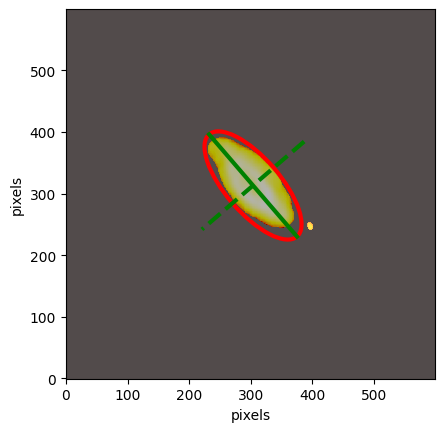

In [17]:
# === Run find_galaxy to get PA, eps, center ===
result = find_galaxy(moment0_map, plot=True)
eps = result.eps
pa = result.pa
theta = result.theta
xpeak = result.xpeak
ypeak = result.ypeak

plt.show()

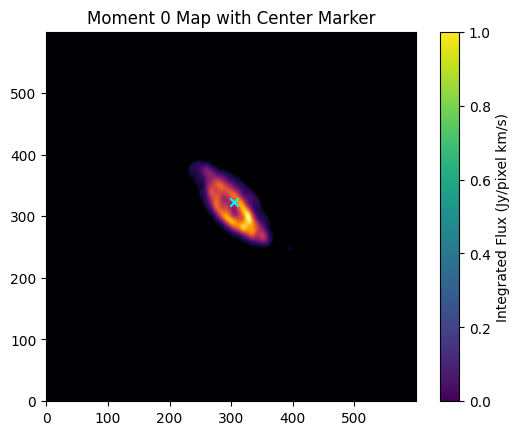

In [19]:
plt.imshow(moment0_map, origin='lower', cmap='inferno')
plt.scatter(xpeak, ypeak, color='cyan', marker='x')  # Visual debug
plt.colorbar(label="Integrated Flux (Jy/pixel km/s)")
plt.title("Moment 0 Map with Center Marker")
plt.show()


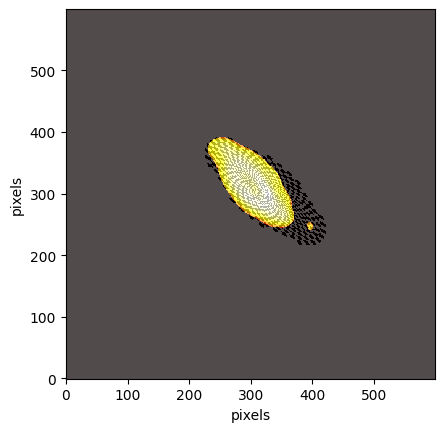

In [20]:
# === Get photometry along sectors ===
s = sectors_photometry(moment0_map, eps, pa, xpeak, ypeak, minlevel=0, plot=True)
plt.show()


In [21]:
print(np.any(np.isnan(s.counts)), np.any(s.counts <= 0))


False False


Starting the LINEAR fit with  100  Gaussians. Please wait...
Iteration:0  chi2: 156.0  Nonzero: 4/100
Nonzero Gaussians: 4/100
Eliminating not useful Gaussians...
ngauss: 3          chi2: 156.6
Starting nonlinear fit...
Iteration:1  chi2: 156.6  Nonzero: 3/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration:1  chi2: 136.1  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
  Computation time: 0.04 seconds
  Total Iterations:  0
 Nonzero Gaussians:  2
  Unused Gaussians:  98
 Sectors used in the fit:  19
 Total number of points fitted:  549
 Chi2: 136.1 
 STDEV: 0.4318 
 MEANABSDEV: 0.3653 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   5.4648e+00        18.29       0.8024
   4.1256e+00        57.48       0.0981
++++++++++++++++++++++++++++++++++++++++++++


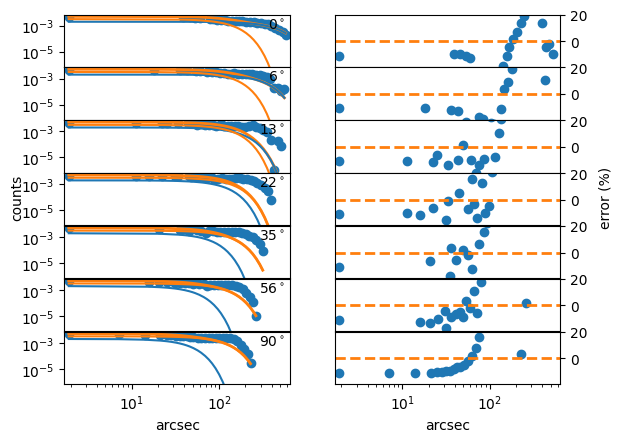

In [22]:
m = mge_fit_sectors(
    radius=s.radius,
    angle=s.angle,
    counts=s.counts,
    eps=eps,
    ngauss=100,
    linear=True,
    scale=HI_SCALE,
    outer_slope=4,
    plot=True
)


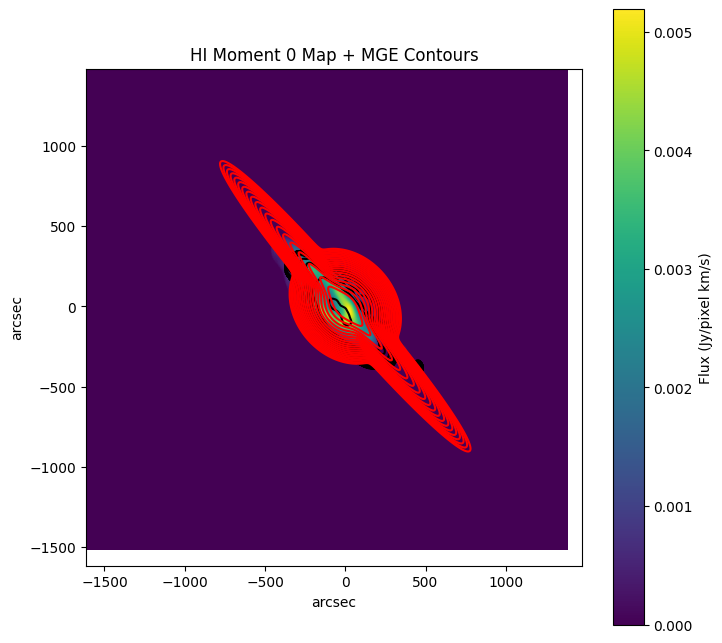

In [23]:
# Plot the moment 0 map
plt.figure(figsize=(8, 8))
plt.imshow(moment0_map, origin='lower', cmap='viridis', extent=extent)
plt.colorbar(label="Flux (Jy/pixel km/s)")
plt.title("HI Moment 0 Map + MGE Contours")

# MGE contours (aligned now!)
mge_print_contours(
    moment0_map,
    theta,          # from find_galaxy
    ypeak, xpeak,   # careful! mge_print_contours uses [y, x] order
    m.sol,
    1,
    10,
    None,
    None,
    np.array([1]),
    HI_SCALE,
    np.array([0])
)

plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()


In [82]:
# 🔧 Manually chosen center of the HI dip (adjustable!)
cx, cy = 300, 320


In [83]:
Y, X = np.indices(original_map.shape)
r = np.sqrt((X - cx)**2 + (Y - cy)**2).astype(int)

# Compute radial profile and fit outer region
r_max = np.max(r)
radial_profile = np.array([np.nanmean(original_map[r == i]) for i in range(r_max)])

r_values = np.arange(len(radial_profile))
mask_fit = (r_values > 20) & (r_values < 60)  # fit outside the dip
g_init = models.Gaussian1D(amplitude=np.nanmax(radial_profile), mean=30, stddev=15)
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, r_values[mask_fit], radial_profile[mask_fit])

# Replace only r < 20 with fitted values
mge_input_map = original_map.copy()
r_replace = r < 20
mge_input_map[r_replace] = g_fit(r[r_replace])


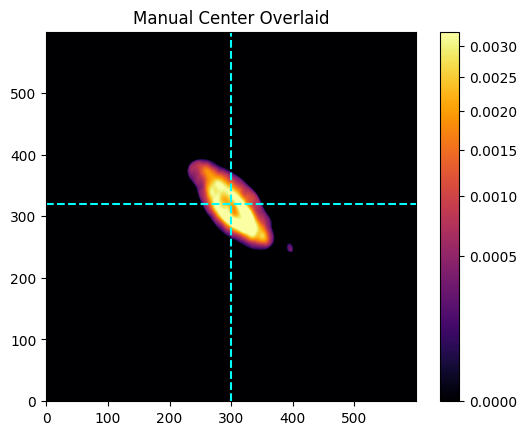

In [84]:
plt.imshow(original_map, origin='lower', cmap='inferno', norm=norm)
plt.axhline(cy, color='cyan', linestyle='--')
plt.axvline(cx, color='cyan', linestyle='--')
plt.title("Manual Center Overlaid")
plt.colorbar()
plt.show()
